# Importing libs and database files 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import pingouin as pg
import seaborn as sns
from modules import analysis
from itertools import combinations
import scikit_posthocs as sp

# Importing Data

In [2]:
# importint a csv file.
project_dir = Path('')
df_gklab = pd.read_csv(
    project_dir / 'df_gklab_analysis_20250611.csv')

# Fix the type of the 'context' column
df_gklab['context'] = df_gklab['context'].astype(pd.Int64Dtype())
df_gklab['context'] = df_gklab['context'].astype(str)
df_gklab['context'] = df_gklab['context'].replace('0', '00')

# Exclude volunteers if needed

In [3]:
lst_excluded_volunteers = []

df_gklab = df_gklab[~df_gklab['ID_info'].isin(lst_excluded_volunteers)]

# Success Rate Analysis
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

       W   pval  normal
1  0.889  0.079    True
2  0.800  0.005   False
3  0.714  0.001   False
4  0.717  0.001   False
5  0.886  0.070    True
6  0.938  0.399    True


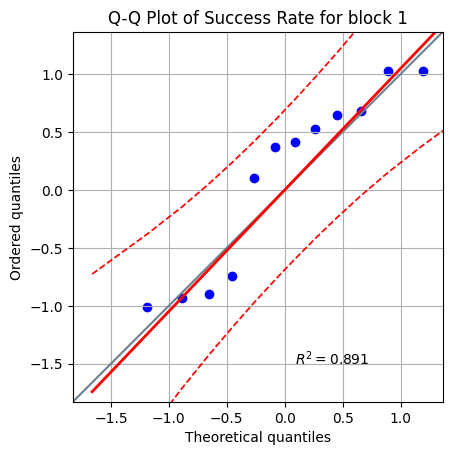

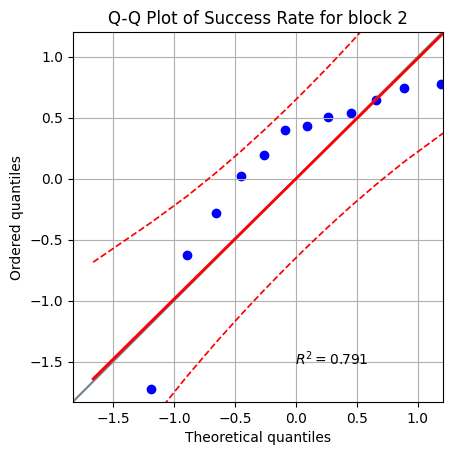

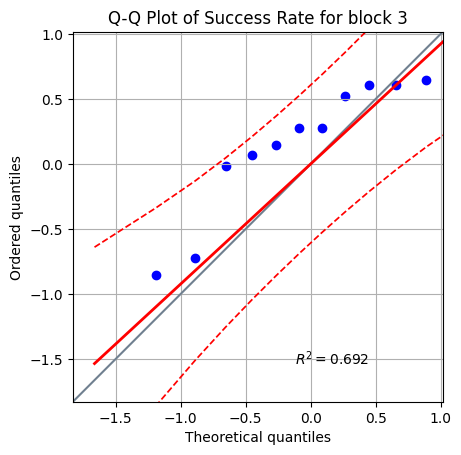

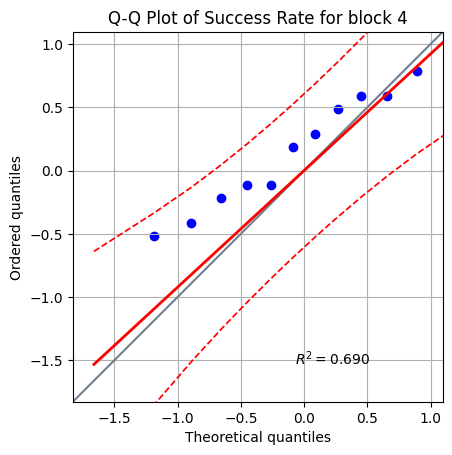

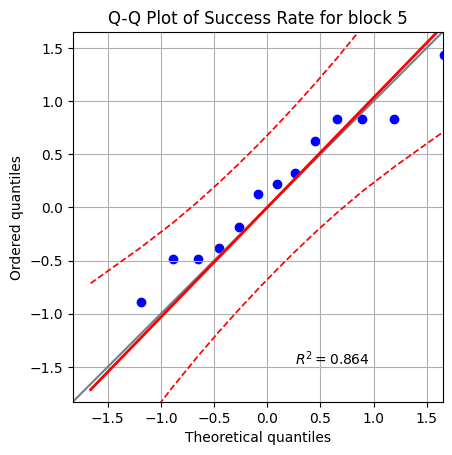

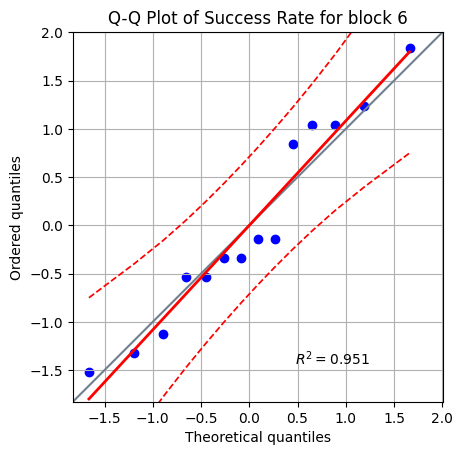

In [4]:
# Calculating mean values of subjects
success_rate_blocks = analysis.calculate_success_rate_by_block_group(df_gklab)

# Convert the dictionary to a DataFrame
success_rate_blocks_df = pd.DataFrame.from_dict(success_rate_blocks, orient='index')

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(success_rate_blocks_df)
print(shapiro_results.round(3))

# Q-Q plots for each block
for column in success_rate_blocks_df.columns:
    plt.figure()  # Create a new figure for each column
    pg.qqplot(success_rate_blocks_df[column], dist='norm')
    plt.title(f'Q-Q Plot of Success Rate for block {column}')
    plt.grid(True)
    plt.show()

# # Histograms for each block
# for column in success_rate_blocks_df.columns:
#     plt.figure()  # Create a new figure for each column
#     sns.histplot(success_rate_blocks_df[column], kde=True)
#     plt.title(f'Histogram of Success Rate for block {column}')
#     plt.xlabel('Success Rate')
#     plt.ylabel('Frequency')
#     plt.show()

In [5]:
# Convert wide format to long format
success_rate_blocks_df = success_rate_blocks_df.melt(var_name='Block', value_name='SuccessRate')

# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=success_rate_blocks_df, 
                          dv='SuccessRate', 
                          between='Block')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = success_rate_blocks_df['Block'].nunique()
n = len(success_rate_blocks_df)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(success_rate_blocks_df, val_col='SuccessRate', group_col='Block', p_adjust='fdr_bh') # Benjamini/Hochberg (non-negative) ‘fdr_bh’
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
        Source  ddof1       H  p-unc
Kruskal  Block      5  27.866    0.0

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.2932

Dunn's Post Hoc Test Results:
       1      2      3      4      5      6
1  1.000  0.024  0.010  0.002  0.000  0.000
2  0.024  1.000  0.782  0.487  0.137  0.137
3  0.010  0.782  1.000  0.699  0.219  0.219
4  0.002  0.487  0.699  1.000  0.438  0.438
5  0.000  0.137  0.219  0.438  1.000  0.988
6  0.000  0.137  0.219  0.438  0.988  1.000


# Response Time in different Buttons Analysis
- Normality and Homocedasticity Tests
- ANOVA one way

                   W   pval  normal
response_info                      
0              0.935  0.358    True
1              0.971  0.883    True
2              0.944  0.474    True


            W   pval  equal_var
levene  0.209  0.812       True


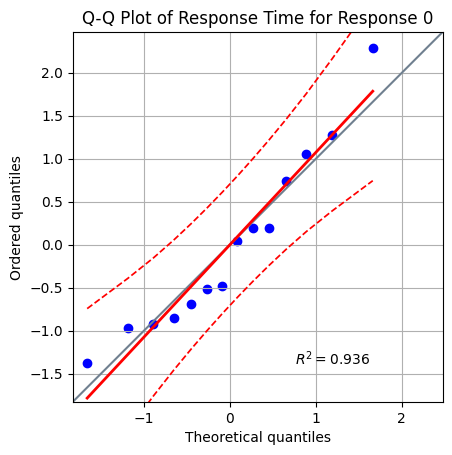

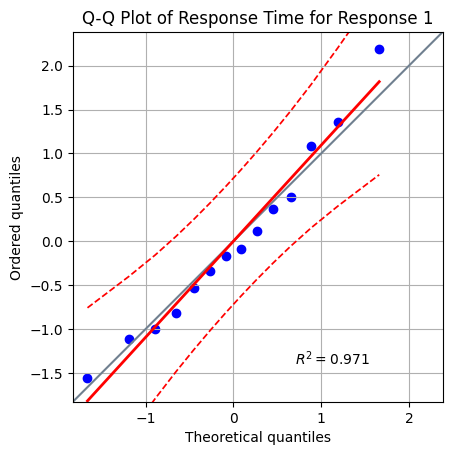

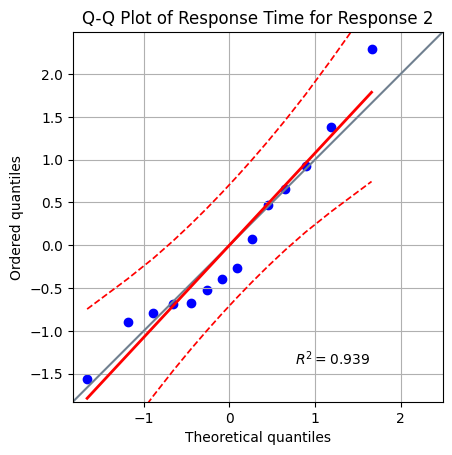

In [6]:
# Calculate mean response times grouped by ID_info and response_info and plot RTs by Responses
mean_response_times_by_responses = df_gklab.groupby(['ID_info', 'response_info'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_by_responses, dv='response_time_info', group='response_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_by_responses, dv='response_time_info', group='response_info')
print(levene_results.round(3))

# Q-Q plots for each response category
response_categories = mean_response_times_by_responses['response_info'].unique()
for response in response_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_by_responses[mean_response_times_by_responses['response_info'] == response]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for Response {response}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for response in response_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_by_responses[mean_response_times_by_responses['response_info'] == response]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for Response {response}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [7]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_by_responses, dv='response_time_info', between='response_info', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))

          Source     SS  DF     MS      F  p-unc  np2
0  response_info  0.037   2  0.019  2.167  0.128  0.1
1         Within  0.334  39  0.009    NaN    NaN  NaN


In [8]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_by_responses, 
                          dv='response_time_info', 
                          between='response_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_responses, val_col='response_time_info', group_col='response_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
                Source  ddof1      H  p-unc
Kruskal  response_info      2  4.052  0.132

No significant differences found; no post hoc analysis needed.


# Response Time by Blocks Analysis
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W   pval  normal
block_info                      
1           0.951  0.581    True
2           0.954  0.630    True
3           0.857  0.027   False
4           0.921  0.226    True
5           0.945  0.488    True
6           0.967  0.832    True


            W   pval  equal_var
levene  0.918  0.474       True


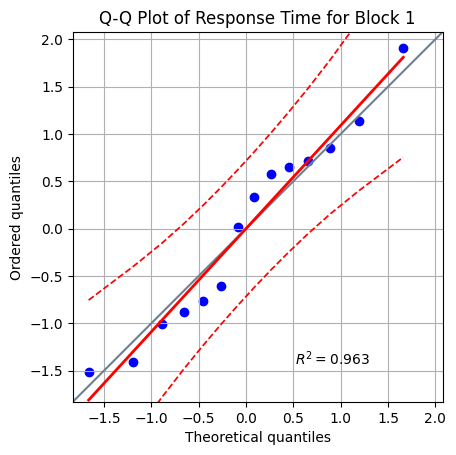

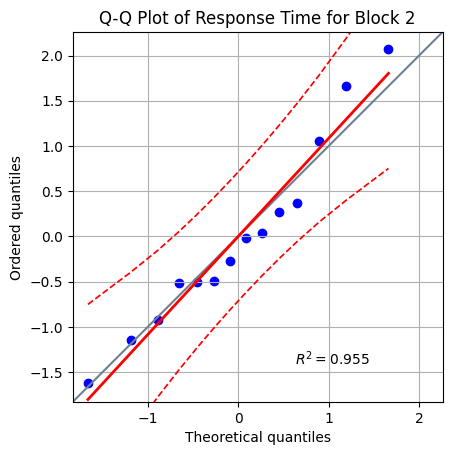

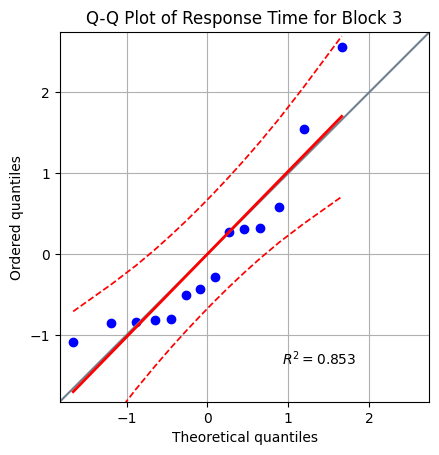

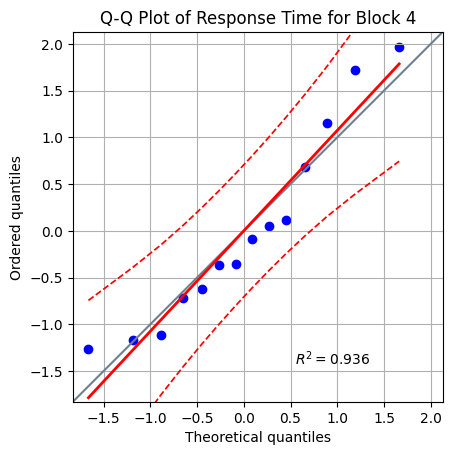

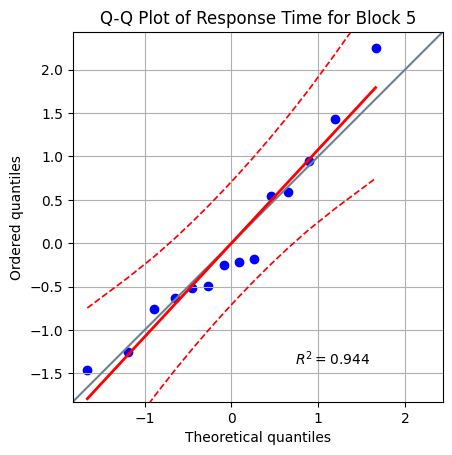

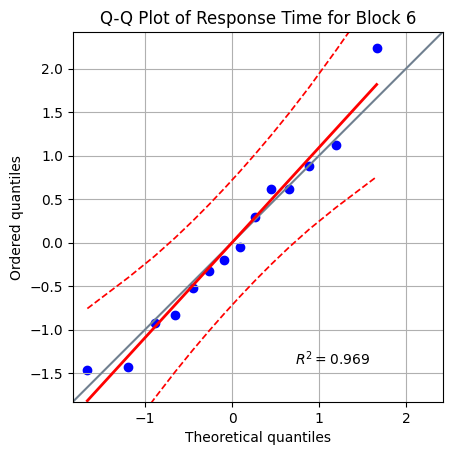

In [9]:
# Calculate mean response times grouped by ID_info and block_info and plot RTs by Blocks
mean_response_times_by_blocks = df_gklab.groupby(['ID_info', 'block_info'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_by_blocks, dv='response_time_info', group='block_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_by_blocks, dv='response_time_info', group='block_info')
print(levene_results.round(3))

# Q-Q plots for each response category
block_categories = mean_response_times_by_blocks['block_info'].unique()
for block in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_by_blocks[mean_response_times_by_blocks['block_info'] == block]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for Block {block}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for block in block_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_by_blocks[mean_response_times_by_blocks['block_info'] == block]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for Block {block}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [10]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_by_blocks, 
                          dv='response_time_info', 
                          between='block_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_by_blocks['block_info'].nunique()
n = len(mean_response_times_by_blocks)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_blocks, val_col='response_time_info', group_col='block_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
             Source  ddof1       H  p-unc
Kruskal  block_info      5  21.519  0.001

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.2118

Dunn's Post Hoc Test Results:
       1      2      3      4      5      6
1  1.000  0.374  0.059  0.011  0.059  0.000
2  0.374  1.000  0.323  0.108  0.323  0.011
3  0.059  0.323  1.000  0.490  0.969  0.140
4  0.011  0.108  0.490  1.000  0.490  0.374
5  0.059  0.323  0.969  0.490  1.000  0.140
6  0.000  0.011  0.140  0.374  0.140  1.000


# Response times with and without TMS pulses
- Normality test
- Unpaired T test

               W   pval  normal
tms_pulse                      
Pulse      0.953  0.606    True
noPulse    0.915  0.185    True


            W   pval  equal_var
levene  1.202  0.283       True


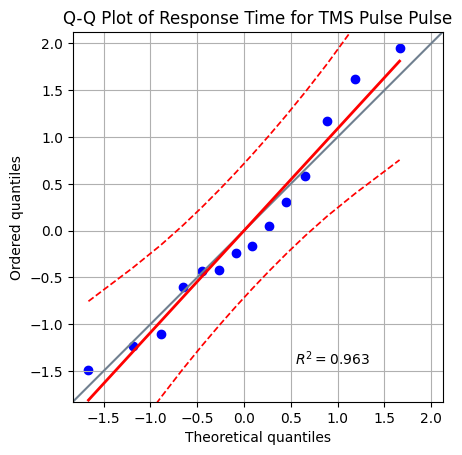

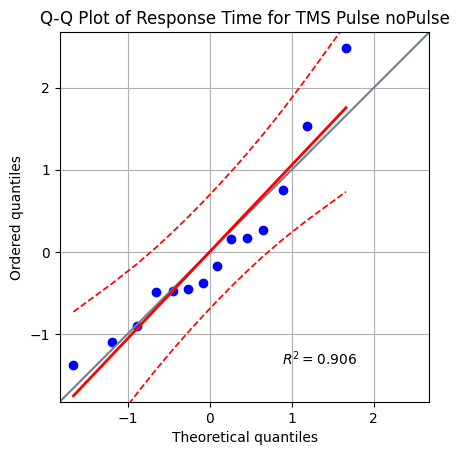

In [11]:
# Calculate mean response times grouped by ID_info and TMS pulse
mean_response_times_NoPulse_Pulse = df_gklab.groupby(['ID_info', 'tms_pulse'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_NoPulse_Pulse, dv='response_time_info', group='tms_pulse')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_NoPulse_Pulse, dv='response_time_info', group='tms_pulse')
print(levene_results.round(3))

# Q-Q plots for each response category
pulse_categories = mean_response_times_NoPulse_Pulse['tms_pulse'].unique()
for i in pulse_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for TMS Pulse {i}')
    plt.grid(True)
    plt.show()
    
# # Histograms for each response category
# for i in pulse_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for TMS Pulse {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [12]:
# Get x and y from dataframe
rt_with_tms = mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == 'Pulse']['response_time_info']
rt_without_tms = mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == 'noPulse']['response_time_info']

# Perform T test
ttest_results = pg.ttest(rt_with_tms, rt_without_tms, correction=False, paired=False)
print(ttest_results.round(3))

            T  dof alternative  p-val          CI95%  cohen-d   BF10  power
T-test -1.318   26   two-sided  0.199  [-0.12, 0.03]    0.498  0.671  0.246


# Response Time by Contexts during TMS pulses
- Normality test
- ANOVA with pairwise T tests and Benjamini/Hochberg correction

                W      pval  normal
context                            
00       0.943667  0.467315    True
1        0.959211  0.710081    True
10       0.929940  0.304552    True
2        0.934804  0.355810    True
20       0.962583  0.765313    True


               W    pval  equal_var
levene  0.082504  0.9875       True


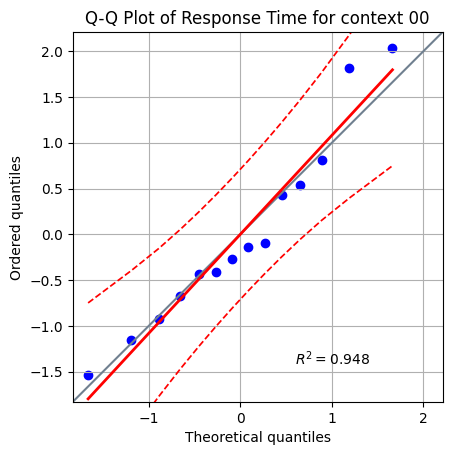

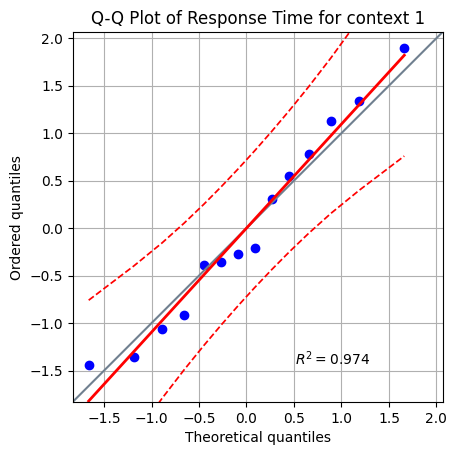

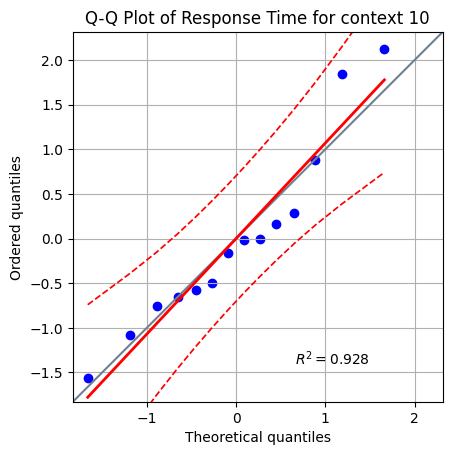

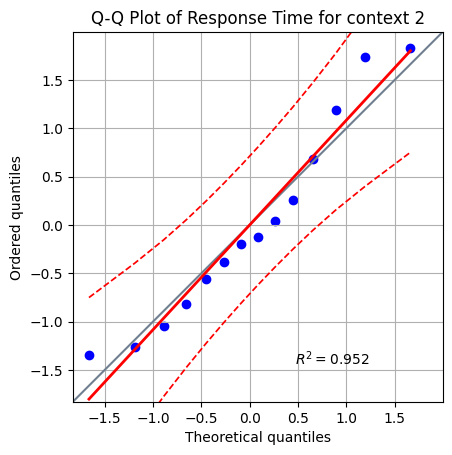

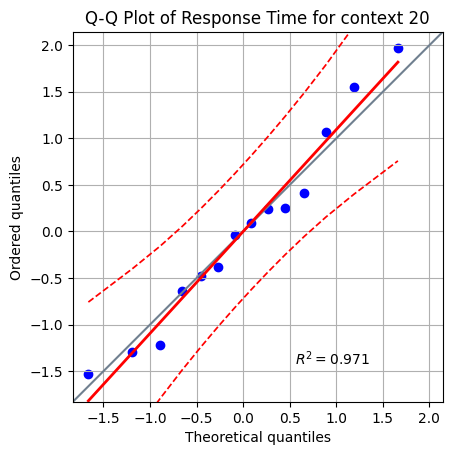

In [13]:
# Filter RTs during pulses
rt_pulse_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse') & (df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts and Plot   
mean_response_times_pulse_ctx = rt_pulse_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_pulse_ctx, dv='response_time_info', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_pulse_ctx, dv='response_time_info', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_response_times_pulse_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_pulse_ctx[mean_response_times_pulse_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_pulse_ctx[mean_response_times_pulse_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [14]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_pulse_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results)
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_pulse_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results)
    
else:
    print("No significant differences found; no post hoc analysis needed.")

    Source        SS  DF        MS         F     p-unc       np2
0  context  0.040344   4  0.010086  0.773102  0.546669  0.045415
1   Within  0.847994  65  0.013046       NaN       NaN       NaN


No significant differences found; no post hoc analysis needed.


In [15]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_pulse_ctx, 
                          dv='response_time_info', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_pulse_ctx['context'].nunique()
n = len(mean_response_times_pulse_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_pulse_ctx, val_col='response_time_info', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
          Source  ddof1      H  p-unc
Kruskal  context      4  3.271  0.514

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: -0.0112

No significant differences found; no post hoc analysis needed.


# Response Time by Contexts without TMS pulses
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W      pval  normal
context                            
00       0.930412  0.309230    True
1        0.935637  0.365277    True
10       0.929244  0.297772    True
2        0.906047  0.138067    True
20       0.915590  0.189921    True


               W      pval  equal_var
levene  0.177613  0.949169       True


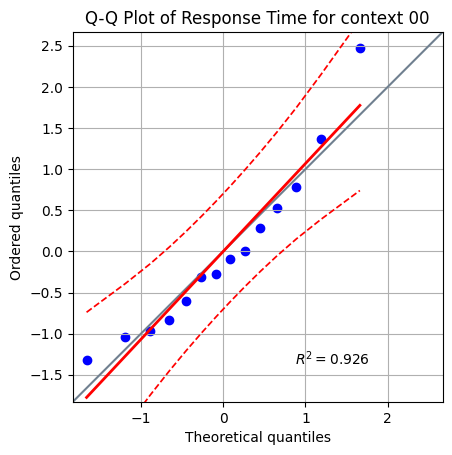

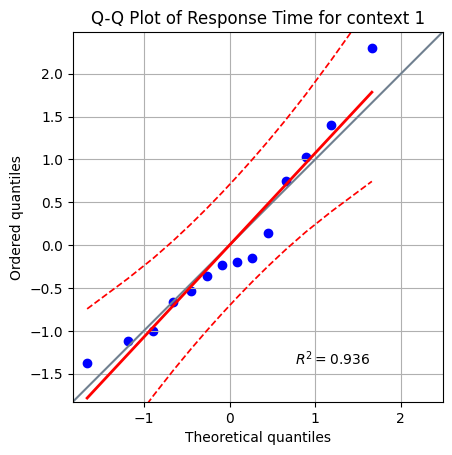

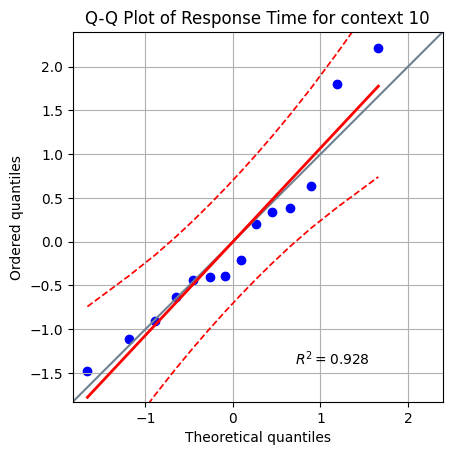

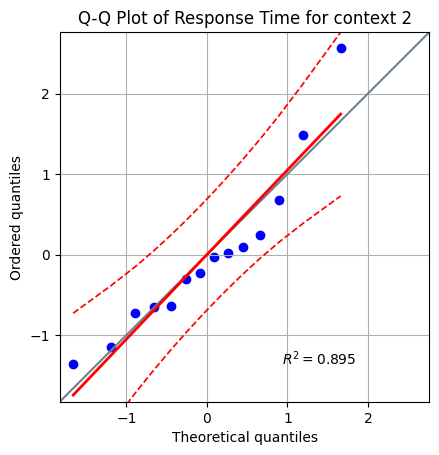

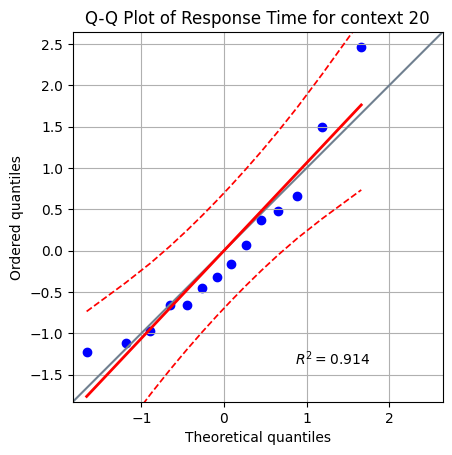

In [16]:
# Filter RTs during pulses
rt_nopulse_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'noPulse') & (df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts and Plot   
mean_response_times_nopulse_ctx = rt_nopulse_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_nopulse_ctx, dv='response_time_info', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_nopulse_ctx, dv='response_time_info', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_response_times_nopulse_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_nopulse_ctx[mean_response_times_nopulse_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_nopulse_ctx[mean_response_times_nopulse_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [17]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_nopulse_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results)
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_nopulse_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results)
    
else:
    print("No significant differences found; no post hoc analysis needed.")

    Source        SS  DF        MS         F   p-unc       np2
0  context  0.069010   4  0.017253  2.731502  0.0364  0.143903
1   Within  0.410549  65  0.006316       NaN     NaN       NaN


  Contrast   A   B  Paired  Parametric         T   dof alternative     p-unc  \
0  context  00   1   False        True -2.342525  26.0   two-sided  0.027083   
1  context  00  10   False        True -0.256462  26.0   two-sided  0.799612   
2  context  00   2   False        True -0.134653  26.0   two-sided  0.893923   
3  context  00  20   False        True  0.740465  26.0   two-sided  0.465653   
4  context   1  10   False        True  2.106699  26.0   two-sided  0.044947   
5  context   1   2   False        True  2.022245  26.0   two-sided  0.053552   
6  context   1  20   False        True  2.957616  26.0   two-sided  0.006522   
7  context  10   2   False        True  0.094778  26.0   two-sided  0.925218   
8  context  10  20   False        True  0.987377  26.0   two-sided  0.332558   
9  contex

In [18]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_nopulse_ctx, 
                          dv='response_time_info', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_nopulse_ctx['context'].nunique()
n = len(mean_response_times_nopulse_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_nopulse_ctx, val_col='response_time_info', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
          Source  ddof1       H  p-unc
Kruskal  context      4  10.224  0.037

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.0958

Dunn's Post Hoc Test Results:
       00      1     10      2     20
00  1.000  0.082  0.899  1.000  0.630
1   0.082  1.000  0.112  0.082  0.025
10  0.899  0.112  1.000  0.899  0.623
2   1.000  0.082  0.899  1.000  0.630
20  0.630  0.025  0.623  0.630  1.000


# Response Time by Contexts with all RTs (n=1200)
- Normality test
- ANOVA with pairwise T test and Benjamini/Hochberg correction

             W   pval  normal
context                      
00       0.924  0.253    True
1        0.945  0.480    True
10       0.898  0.107    True
2        0.944  0.467    True
20       0.957  0.678    True


            W   pval  equal_var
levene  0.153  0.961       True


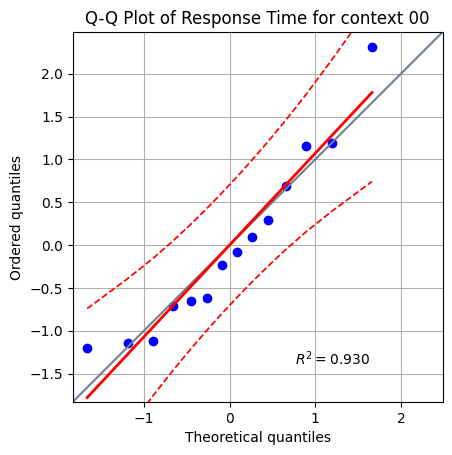

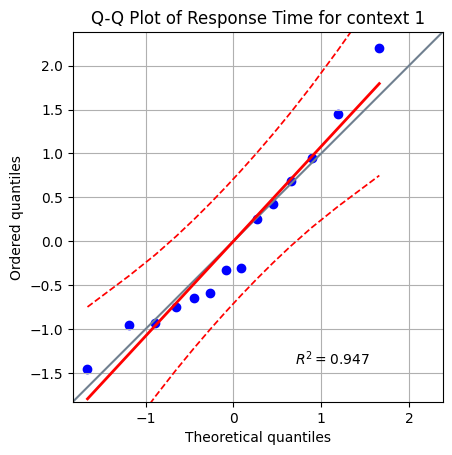

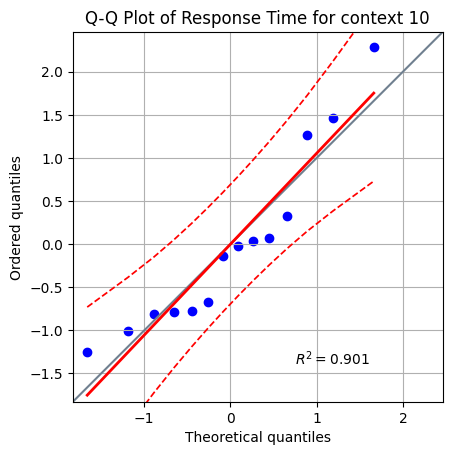

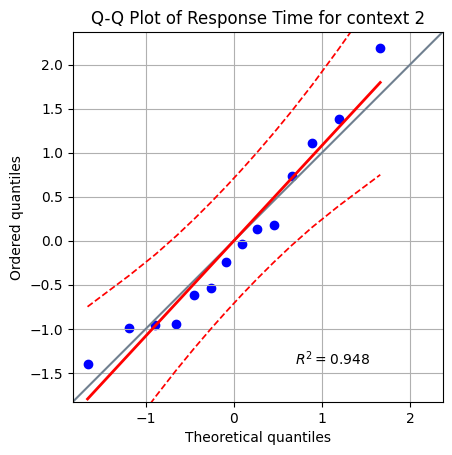

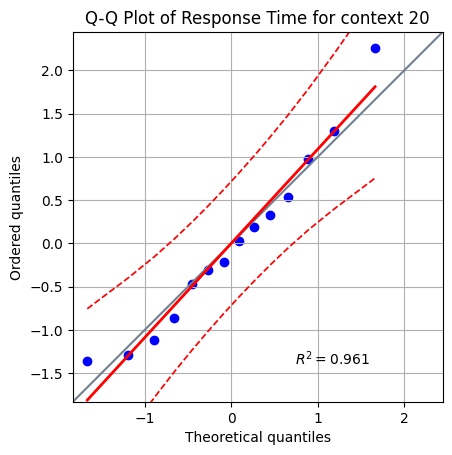

In [19]:
# Filter RTs
rt_df = df_gklab.loc[(df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts
mean_response_times_ctx = rt_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_ctx, dv='response_time_info', group='context')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_ctx, dv='response_time_info', group='context')
print(levene_results.round(3))

# Q-Q plots for each response category
ctx_categories = mean_response_times_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_ctx[mean_response_times_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_ctx[mean_response_times_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [20]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results.round(3))
    
else:
    print("No significant differences found; no post hoc analysis needed.")

    Source     SS  DF     MS      F  p-unc   np2
0  context  0.053   4  0.013  1.598  0.186  0.09
1   Within  0.541  65  0.008    NaN    NaN   NaN


No significant differences found; no post hoc analysis needed.


# Diference between error and success by Contexts during TMS pulse Analysis
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction or T-Test with Benjamini/Hochberg Correction

                W      pval  normal
context                            
00       0.954519  0.632795    True
1        0.883036  0.064212    True
10       0.960773  0.735803    True
2        0.984020  0.991767    True
20       0.979066  0.969036    True


               W      pval  equal_var
levene  4.706596  0.002132      False


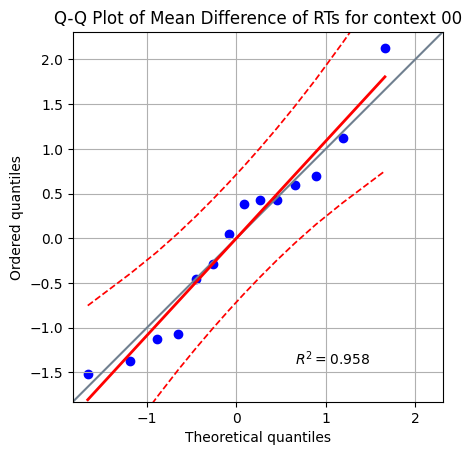

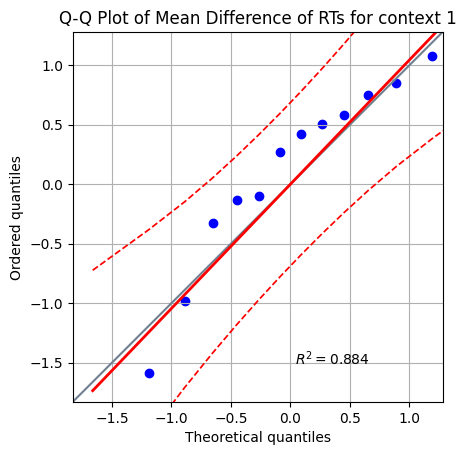

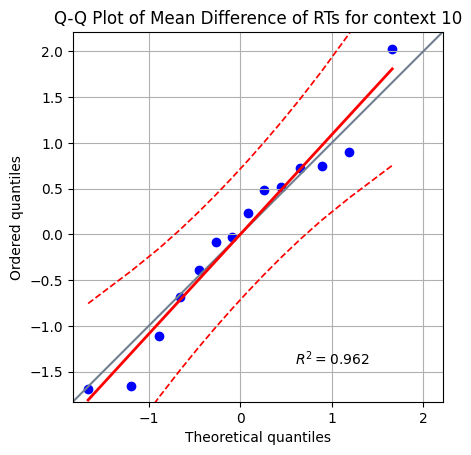

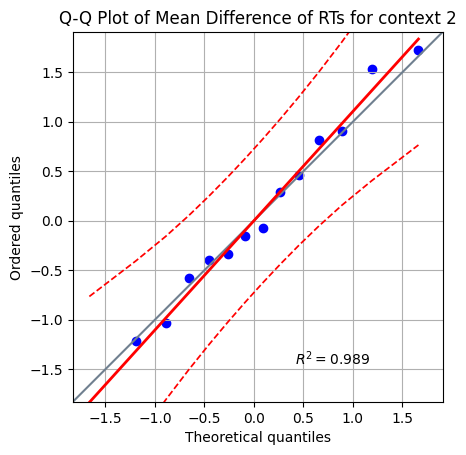

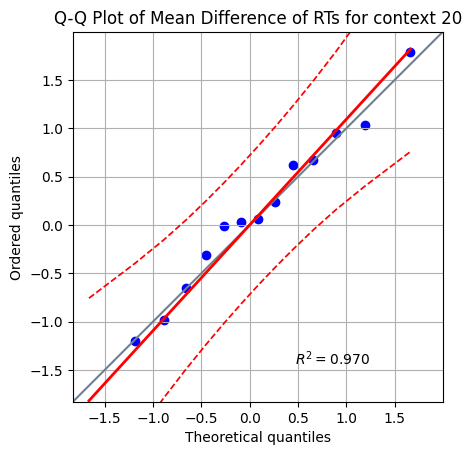

In [21]:
# Get Mean Response Times by Contexts and Plot   
mean_response_times_ctx_prevresult = rt_pulse_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()


In [22]:
### Using Wilcoxon signed rank test with Benjamini-Hochberg correction

from statsmodels.stats.multitest import multipletests

# Assuming stacked_df is your DataFrame
results_list = []
p_values = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    results = pg.wilcoxon(context_data['mean_difference'], context_data['reference'])
    
    # Collect p-value for Benjamini-Hochberg correction
    p_values.append(results['p-val'].iloc[0])
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'W': results['W-val'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'alternative': results['alternative'].iloc[0],
        'RBC': results['RBC'].iloc[0],
        'CLES': results['CLES'].iloc[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini-Hochberg correction
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = adjusted_p_values

results_df.round(3)

,context,W,p-val,alternative,RBC,CLES,adjusted_p-val
0,00,24.0,0.078,two-sided,-0.543,0.286,0.392
1,1,50.0,0.903,two-sided,0.048,0.571,0.903
2,10,48.0,0.808,two-sided,-0.086,0.500,0.903
3,2,49.0,0.855,two-sided,0.067,0.500,0.903
4,20,30.0,0.173,two-sided,0.429,0.714,0.432


In [23]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)


,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,-1.891,0.081,0.715,0.406,False
1,1,-0.359,0.726,0.136,0.726,False
2,10,-0.502,0.624,0.190,0.726,False
3,2,0.368,0.719,0.139,0.726,False
4,20,1.204,0.250,0.455,0.625,False


# Diference between error and success by Contexts without TMS pulse Analysis
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction

                W      pval  normal
context                            
00       0.952176  0.594975    True
1        0.923155  0.244050    True
10       0.976038  0.945294    True
2        0.972121  0.903670    True
20       0.916250  0.194143    True


               W      pval  equal_var
levene  1.644381  0.173796       True


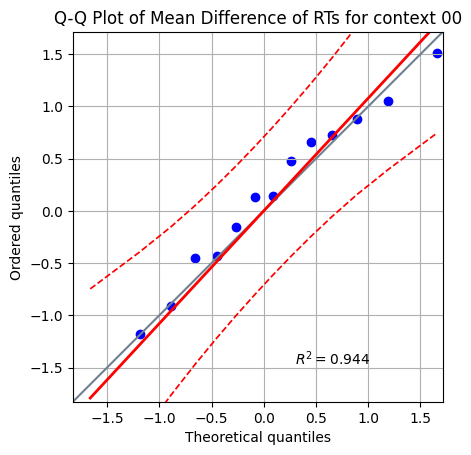

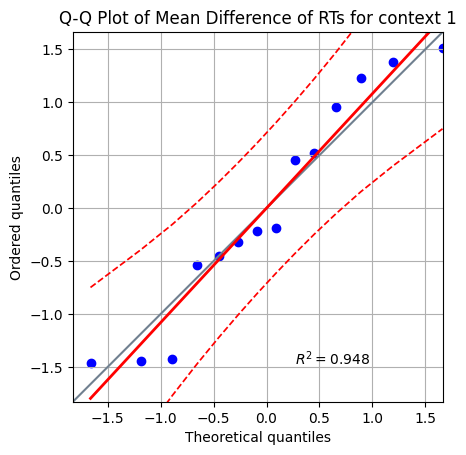

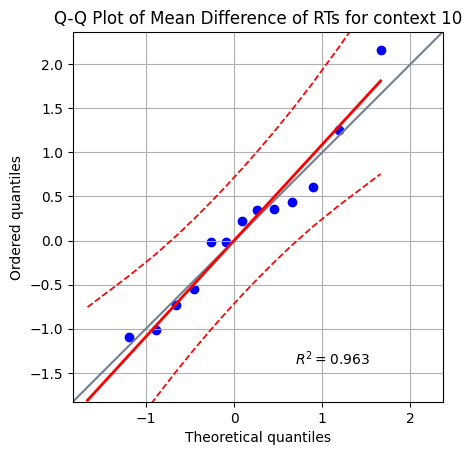

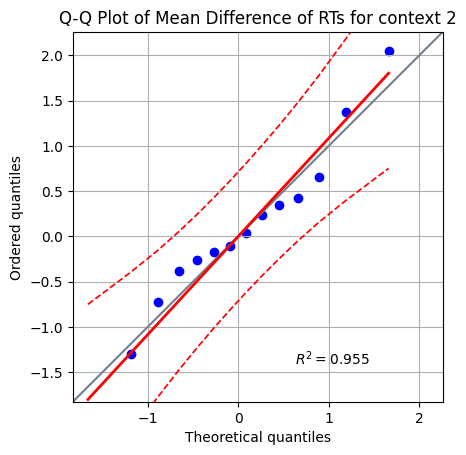

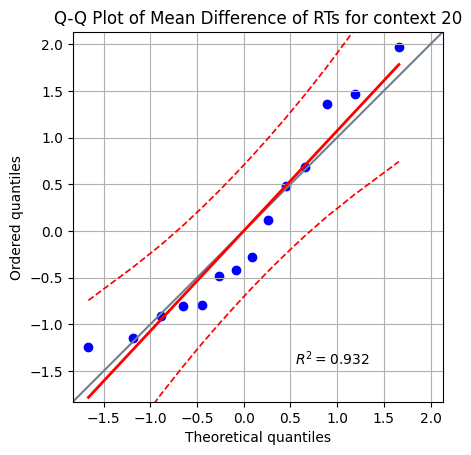

In [24]:
# Get Mean Response Times by Contexts and Plot   
mean_response_times_ctx_prevresult = rt_nopulse_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()


In [25]:
### Using Wilcoxon signed rank test with Benjamini-Hochberg correction

from statsmodels.stats.multitest import multipletests

# Assuming stacked_df is your DataFrame
results_list = []
p_values = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    results = pg.wilcoxon(context_data['mean_difference'], context_data['reference'])
    
    # Collect p-value for Benjamini-Hochberg correction
    p_values.append(results['p-val'].iloc[0])
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'W': results['W-val'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'alternative': results['alternative'].iloc[0],
        'RBC': results['RBC'].iloc[0],
        'CLES': results['CLES'].iloc[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini-Hochberg correction
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = adjusted_p_values

results_df.round(3)

,context,W,p-val,alternative,RBC,CLES,adjusted_p-val
0,00,35.0,0.296,two-sided,-0.333,0.429,0.543
1,1,45.0,0.670,two-sided,0.143,0.429,0.670
2,10,25.0,0.091,two-sided,-0.524,0.214,0.453
3,2,36.0,0.326,two-sided,0.314,0.643,0.543
4,20,42.0,0.542,two-sided,0.200,0.500,0.670


In [26]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)

,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,-1.308,0.214,0.494,0.504,False
1,1,0.524,0.609,0.198,0.609,False
2,10,-1.645,0.124,0.622,0.504,False
3,2,0.790,0.444,0.299,0.554,False
4,20,1.073,0.303,0.406,0.504,False


# Diference between error and success by Contexts with all RTs (n = 1200)
- Normality test
- ANOVA

                W      pval  normal
context                            
00       0.954816  0.637642    True
1        0.969757  0.873393    True
10       0.895135  0.095884    True
2        0.935902  0.368340    True
20       0.951770  0.588513    True


               W     pval  equal_var
levene  3.001829  0.02457      False


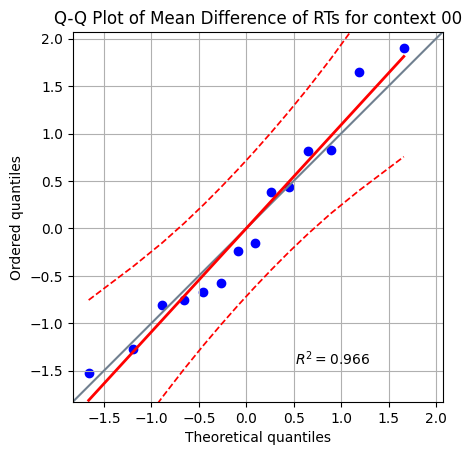

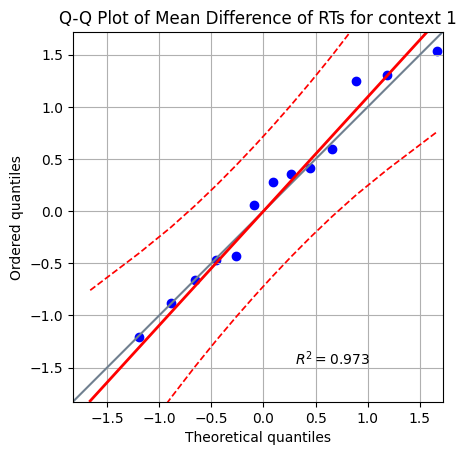

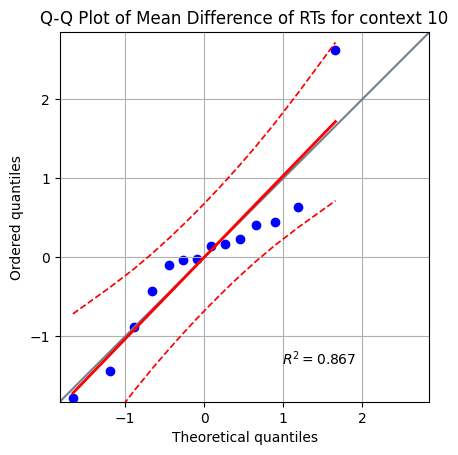

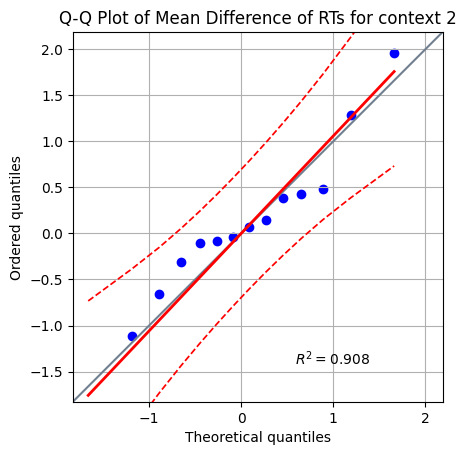

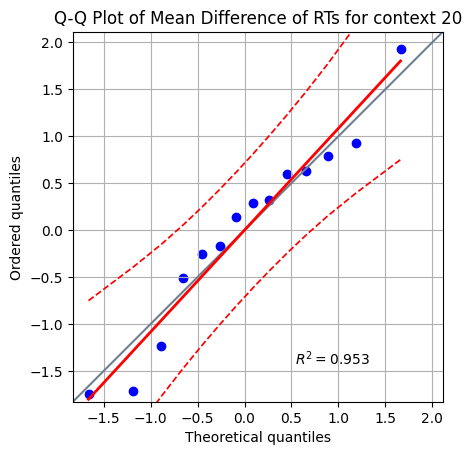

In [27]:
# Get Mean Response Times by Contexts and Plot   
mean_all_response_times_ctx_prevresult = rt_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_all_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()

In [28]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)

,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,-1.826,0.091,0.690,0.227,False
1,1,0.307,0.764,0.116,0.764,False
2,10,-1.144,0.273,0.432,0.407,False
3,2,1.022,0.326,0.386,0.407,False
4,20,2.807,0.015,1.061,0.074,False


# MEP differences between blocks
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W   pval  normal
block_info                      
2           0.922  0.238    True
4           0.873  0.046   False
6           0.718  0.001   False


            W   pval  equal_var
levene  0.246  0.783       True


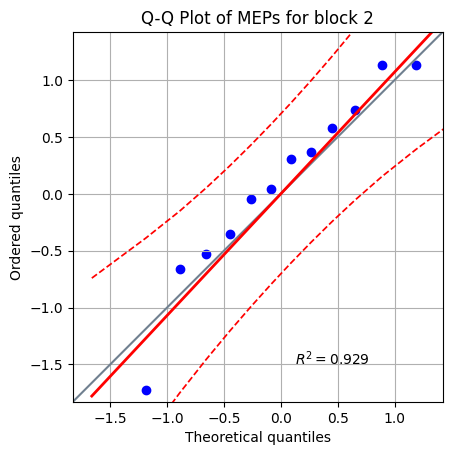

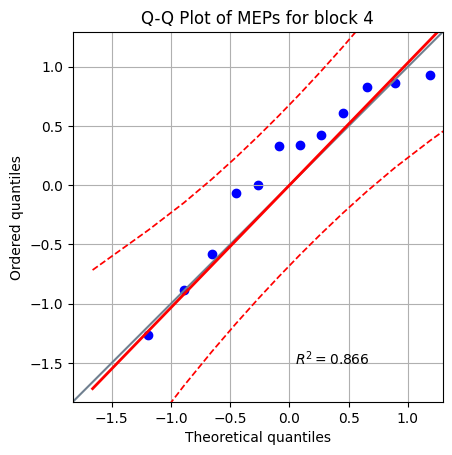

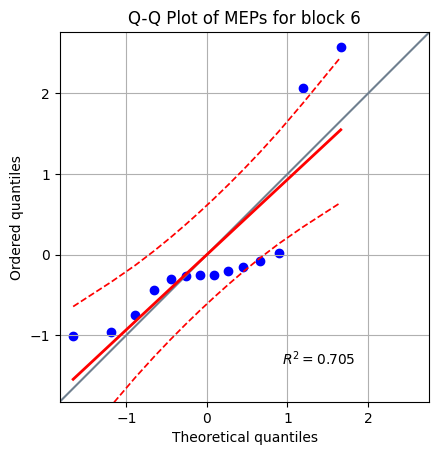

In [29]:
# Filter MEPs during pulses
meps_blocks_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse')]

# Calculate mean FDI MEPs grouped by ID_info and block_info
mean_FDImeps_by_blocks = meps_blocks_df.groupby(['ID_info', 'block_info'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_FDImeps_by_blocks, dv='relMean_MEPpp_FDI', group='block_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_FDImeps_by_blocks, dv='relMean_MEPpp_FDI', group='block_info')
print(levene_results.round(3))

# Q-Q plots for each MEP block
block_categories = mean_FDImeps_by_blocks['block_info'].unique()
for i in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_FDImeps_by_blocks[mean_FDImeps_by_blocks['block_info'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of MEPs for block {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in block_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_FDImeps_by_blocks[mean_FDImeps_by_blocks['block_info'] == i]['relMean_MEPpp_FDI'], kde=True)
#     plt.title(f'Histogram of FDI MEPs for block {i}')
#     plt.xlabel('FDI MEPs')
#     plt.ylabel('Frequency')
#     plt.show()

In [30]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_FDImeps_by_blocks, 
                          dv='relMean_MEPpp_FDI', 
                          between='block_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_FDImeps_by_blocks['block_info'].nunique()
n = len(mean_FDImeps_by_blocks)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_blocks, val_col='relMean_MEPpp_FDI', group_col='block_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
             Source  ddof1      H  p-unc
Kruskal  block_info      2  2.776   0.25

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.0199

No significant differences found; no post hoc analysis needed.


# FDI MEP differences by contexts
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W      pval  normal
context                            
00       0.970548  0.883901    True
1        0.916363  0.194877    True
10       0.876090  0.051138    True
2        0.966821  0.831511    True
20       0.901706  0.119401    True


               W      pval  equal_var
levene  2.123809  0.087813       True


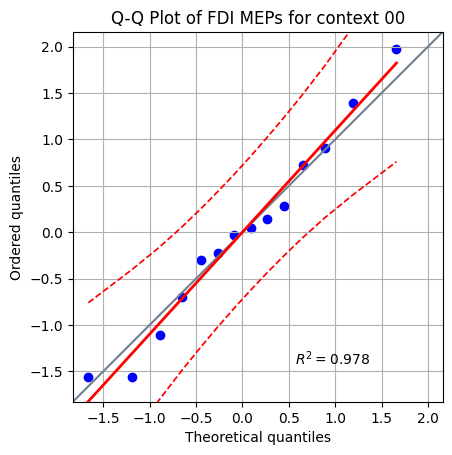

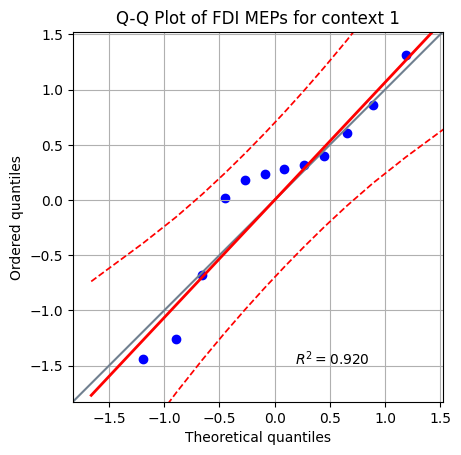

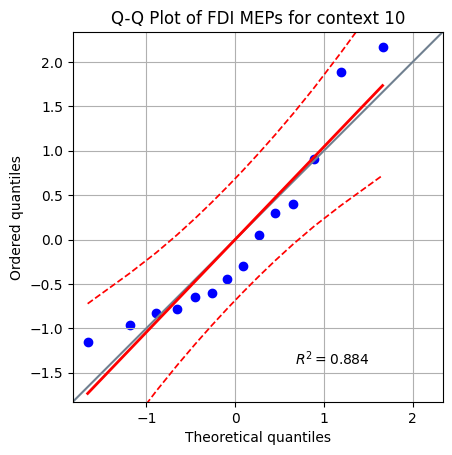

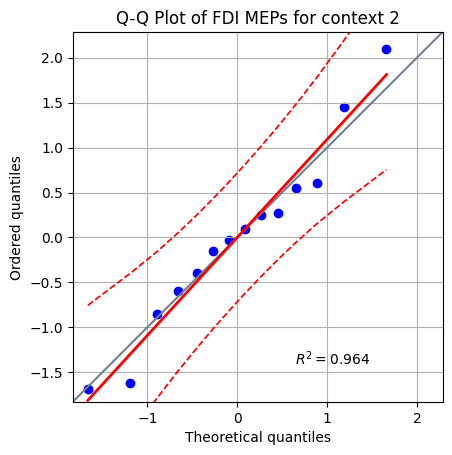

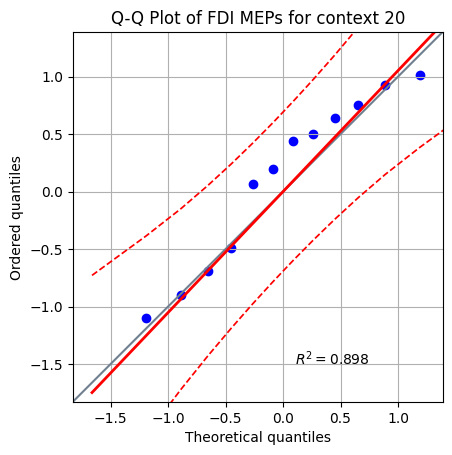

In [31]:
# Filter MEPs during pulses
meps_blocks_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse') & (df_gklab['context'] != '<NA>')]

# Get Mean FDI MEPs relative to mean by Contexts    
mean_relmFDImepsmean_ctx = meps_blocks_df.groupby(['ID_info', 'context'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_relmFDImepsmean_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_relmFDImepsmean_ctx[mean_relmFDImepsmean_ctx['context'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_relmFDImepsmean_ctx[mean_relmFDImepsmean_ctx['context'] == i]['relMean_MEPpp_FDI'], kde=True)
#     plt.title(f'Histogram of FDI MEPs for context {i}')
#     plt.xlabel('FDI MEPs')
#     plt.ylabel('Frequency')
#     plt.show()

In [32]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Perform post hoc tests with Benjamini/Hochberg correction
posthoc_results = pg.pairwise_tests(data=mean_relmFDImepsmean_ctx, 
                                     dv='relMean_MEPpp_FDI', 
                                     between='context', 
                                     padjust='fdr_bh')

# Print the post hoc results
print(posthoc_results.round(3))

    Source     SS  DF     MS      F  p-unc    np2
0  context  0.042   4  0.010  4.099  0.005  0.201
1   Within  0.166  65  0.003    NaN    NaN    NaN


  Contrast   A   B  Paired  Parametric      T   dof alternative  p-unc  \
0  context  00   1   False        True -0.098  26.0   two-sided  0.923   
1  context  00  10   False        True -2.503  26.0   two-sided  0.019   
2  context  00   2   False        True -1.059  26.0   two-sided  0.299   
3  context  00  20   False        True  0.491  26.0   two-sided  0.627   
4  context   1  10   False        True -2.869  26.0   two-sided  0.008   
5  context   1   2   False        True -1.231  26.0   two-sided  0.229   
6  context   1  20   False        True  0.884  26.0   two-sided  0.385   
7  context  10   2   False        True  1.575  26.0   two-sided  0.127   
8  context  10  20   False        True  3.328  26.0   two-sided  0.003   
9  context   2  20   False        True  1.801  26.0   two-sided  0.083   

   p-corr p-adjust    BF10  hedge

In [33]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_relmFDImepsmean_ctx, 
                          dv='relMean_MEPpp_FDI', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_relmFDImepsmean_ctx, val_col='relMean_MEPpp_FDI', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
          Source  ddof1       H  p-unc
Kruskal  context      4  11.031  0.026

Dunn's Post Hoc Test Results:
          00         1        10         2        20
00  1.000000  0.852663  0.076822  0.403302  0.670054
1   0.852663  1.000000  0.084081  0.407950  0.600434
10  0.076822  0.084081  1.000000  0.403302  0.032432
2   0.403302  0.407950  0.403302  1.000000  0.190305
20  0.670054  0.600434  0.032432  0.190305  1.000000


## Analysing FDS MEPs by context

                W      pval  normal
context                            
00       0.957364  0.679542    True
1        0.893502  0.090808    True
10       0.963200  0.775235    True
2        0.922378  0.237883    True
20       0.961212  0.743008    True


               W      pval  equal_var
levene  0.334884  0.853502       True


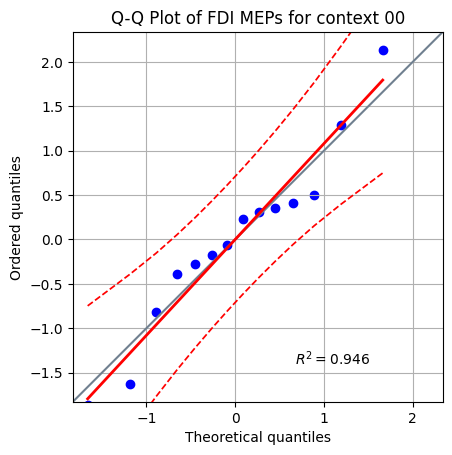

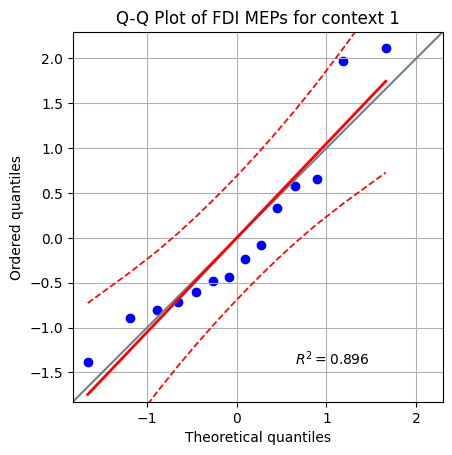

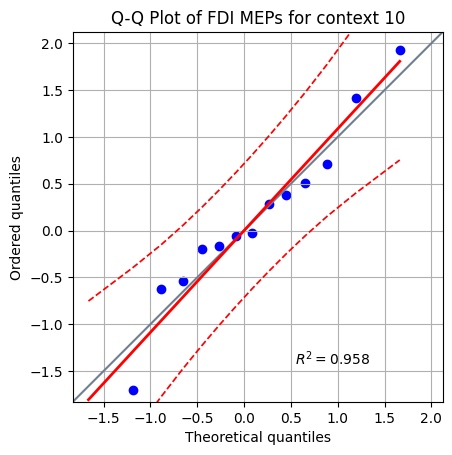

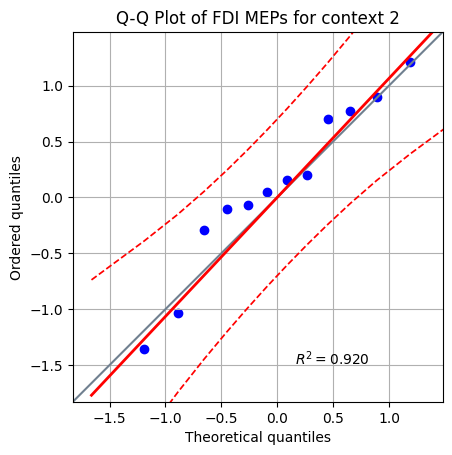

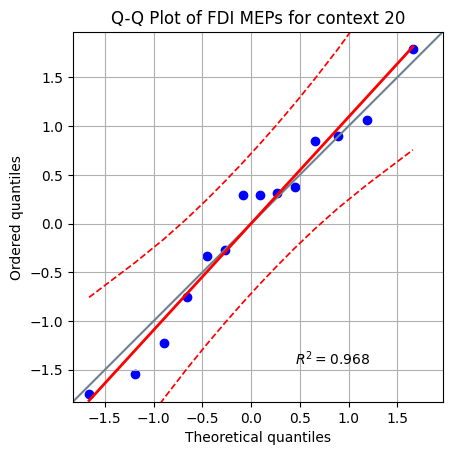

In [34]:
# Get Mean FDS MEPs relative to mean by Contexts    
mean_relmFDSmepsmean_ctx = meps_blocks_df.groupby(['ID_info', 'context'])['relMean_MEPpp_FDS'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_relmFDSmepsmean_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_relmFDSmepsmean_ctx[mean_relmFDSmepsmean_ctx['context'] == i]['relMean_MEPpp_FDS'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs for context {i}')
    plt.grid(True)
    plt.show()

In [35]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Perform post hoc tests with Benjamini/Hochberg correction
posthoc_results = pg.pairwise_tests(data=mean_relmFDSmepsmean_ctx, 
                                     dv='relMean_MEPpp_FDS', 
                                     between='context', 
                                     padjust='fdr_bh')

# Print the post hoc results
print(posthoc_results.round(3))

    Source     SS  DF     MS       F  p-unc    np2
0  context  0.118   4  0.030  10.684    0.0  0.397
1   Within  0.180  65  0.003     NaN    NaN    NaN


  Contrast   A   B  Paired  Parametric      T   dof alternative  p-unc  \
0  context  00   1   False        True -4.703  26.0   two-sided  0.000   
1  context  00  10   False        True -1.208  26.0   two-sided  0.238   
2  context  00   2   False        True  0.479  26.0   two-sided  0.636   
3  context  00  20   False        True  0.958  26.0   two-sided  0.347   
4  context   1  10   False        True  3.318  26.0   two-sided  0.003   
5  context   1   2   False        True  4.964  26.0   two-sided  0.000   
6  context   1  20   False        True  5.229  26.0   two-sided  0.000   
7  context  10   2   False        True  1.596  26.0   two-sided  0.123   
8  context  10  20   False        True  1.990  26.0   two-sided  0.057   
9  context   2  20   False        True  0.482  26.0   two-sided  0.634   

   p-corr p-adjust     BF10  h

# MEP diference between error and success by Contexts
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction or T-Test with Benjamini/Hochberg Correction

In [ ]:
# Get Mean FDI MEPs by Contexts and Previous Result and Plot    
mean_FDImeps_ctx_prevresult = meps_blocks_df.groupby(['ID_info', 'context', 'last_was_error'])['relMean_MEPpp_FDI'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_FDImeps_ctx_prevresult,
                            values='relMean_MEPpp_FDI',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs Mean Difference for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of FDI MEPs Mean Difference for context {i}')
#     plt.xlabel('FDI MEPs Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df